In [1]:
import torch
from einops import rearrange
import numpy as np
import pickle
import os
from tqdm import tqdm
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, AutoConfig
import argparse
from data import load_dataset
from baukit import Trace, TraceDict

import sys
sys.path.append('./')
from llama_utils import alt_tqa_evaluate, flattened_idx_to_layer_head, layer_head_to_flattened_idx, \
get_interventions_dict, get_top_heads, get_separated_activations, get_com_directions
from functools import partial

2025-01-05 20:34:17.875845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736109257.893323      82 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736109257.898715      82 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
HF_NAMES = {
    'llama3.1_8B': 'meta-llama/Llama-3.1-8B'
}

sys.argv = [
    'notebook',
    '--model_name', 'llama3.1_8B',
    '--model_prefix', '',
    '--dataset_name', 'uncertainty',
    '--activations_dataset', 'uncertainty',
    '--num_heads', '48',
    '--alpha', '5',  # Corrected to use --alpha
    '--num_fold', '2',  # Corrected to use --num_fold
    '--val_ratio', '0.2',
    '--use_center_of_mass',
    '--device', '0',
    '--seed', '42',
]

parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='llama_7B', choices=HF_NAMES.keys(), help='model name')
parser.add_argument('--model_prefix', type=str, default='', help='prefix to model name')
parser.add_argument('--dataset_name', type=str, default='tqa_mc2', help='feature bank for training probes')
parser.add_argument('--activations_dataset', type=str, default='tqa_gen_end_q', help='feature bank for calculating std along direction')
parser.add_argument('--num_heads', type=int, default=48, help='K, number of top heads to intervene on')
parser.add_argument('--alpha', type=float, default=15, help='alpha, intervention strength')
parser.add_argument("--num_fold", type=int, default=2, help="number of folds")
parser.add_argument('--val_ratio', type=float, help='ratio of validation set size to development set size', default=0.2)
parser.add_argument('--use_center_of_mass', action='store_true', help='use center of mass direction', default=False)
parser.add_argument('--use_random_dir', action='store_true', help='use random direction', default=False)
parser.add_argument('--device', type=int, default=0, help='device')
parser.add_argument('--seed', type=int, default=42, help='seed')
parser.add_argument('--judge_name', type=str, required=False)
parser.add_argument('--info_name', type=str, required=False)
parser.add_argument('--instruction_prompt', default='default', help='instruction prompt for truthfulqa benchmarking, "default" or "informative"', type=str, required=False)

args = parser.parse_args()

#set seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

data_v = load_dataset('./data/verifiable.csv')
data_nv = load_dataset('./data/non-verifiable.csv')
data_v_100 = data_v[-100:]
data_nv_100 = data_nv[-100:]
data_all = data_v_100 + data_nv_100
print(len(data_all))

golden_q_order = list(data_all)
print(type(golden_q_order))
df = pd.DataFrame(data_all, columns=['Question'])
print(type(df))

900it [00:00, 21682.46it/s]
900it [00:00, 30664.85it/s]

200
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [3]:
# get two folds using numpy
fold_idxs = np.array_split(np.arange(len(df)), args.num_fold)

print(fold_idxs)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199]

In [4]:
#create model
model_name = HF_NAMES[args.model_name]
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map='auto')
if tokenizer.pad_token is None:
    tokenizer.pan_token = tokenizer.eos_token
model.generation_config.pad_token_id = tokenizer.pad_token_id

# define number of layers and heads
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
print(args.model_name, args.dataset_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

llama3.1_8B uncertainty


In [5]:
# load activations
head_wise_activations = np.load(f'./features/{args.model_name}_{args.dataset_name}_head_wise.npy')
labels = np.load(f'./features/{args.model_name}_{args.dataset_name}_labels.npy')
head_wise_activations = rearrange(head_wise_activations, 'b l (h d) -> b l h d', h=num_heads)

# tuning daataset: no labels used, just to get std of activations along the direction
activations_dataset = args.dataset_name if args.activations_dataset is None else args.activations_dataset
tuning_activations = np.load(f'./features/{args.model_name}_{activations_dataset}_head_wise.npy')
tuning_activations = rearrange(tuning_activations, 'b l (h d) -> b l h d', h=num_heads)
tuning_labels = np.load(f'./features/{args.model_name}_{activations_dataset}_labels.npy')

# seperated_head_wise_activations, seperated_labels, idxs_to_split_at = get_separated_activations(labels, head_wise_activations)

In [6]:
results = []

i = 0
fold_idxs[0] = list(range(0, 200, 2))
fold_idxs[1] = list(range(1, 200, 2))
train_idxs = np.concatenate([fold_idxs[j] for j in range(args.num_fold) if j != i])
test_idxs = fold_idxs[i]
print(train_idxs, test_idxs)

[  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143
 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179
 181 183 185 187 189 191 193 195 197 199] [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198]


In [7]:
train_set_idxs = np.random.choice(train_idxs, size=int(len(train_idxs)*(1-args.val_ratio)), replace=False)
print(train_set_idxs)
val_set_idxs = np.array([x for x in train_idxs if x not in train_set_idxs])
print(val_set_idxs)

[167 107 141  91  89  79  45 161  21   1  37  61 147  67 181   9 153 155
  25  63 111 177  53  85 139  31  81 193  19 145  23  95 171  57 187  11
 133 131  71  33  99  69  15 191  55  39 163  51 125  27  49   7  35  77
  17 157  13 129  73 179 113 199 109  87 101 135  93 137 123 195 159  83
 117  97 197 115 151  65 189 119]
[  3   5  29  41  43  47  59  75 103 105 121 127 143 149 165 169 173 175
 183 185]


In [8]:
df.iloc[train_set_idxs].to_csv(f'splits/fold_{i}_train_seed_{args.seed}.csv', index=False)
df.iloc[val_set_idxs].to_csv(f'splits/fold_{i}_val_seed_{args.seed}.csv', index=False)
df.iloc[test_idxs].to_csv(f'splits.fold_{i}_test_seed_{args.seed}.csv', index=False)

print(head_wise_activations.shape, len(labels))

(200, 32, 32, 128) 200


In [9]:
# activation = head_wise_activations
# label = labels
# true_activations = activations[labels == 1]
# false_activations = activations[labels == 0]
# true_mass_mean = np.mean(true_activations, axis=0)
# false_mass_mean = np.mean(false_activations, axis=0)

In [10]:
if args.use_center_of_mass:
    com_directions = get_com_directions(num_layers, num_heads, train_set_idxs, val_set_idxs, head_wise_activations, labels)

top_heads, probes = get_top_heads(train_set_idxs, val_set_idxs, head_wise_activations, labels, num_layers, num_heads, args.seed, args.num_heads, args.use_random_dir)

# print("Heads intervened: ", sorted(top_heads))

# please check the attention head
interventions = get_interventions_dict(top_heads, probes, tuning_activations, num_heads, args.use_center_of_mass, args.use_random_dir, com_directions)

# print(interventions)

train_probes: 100%|██████████| 32/32 [00:02<00:00, 12.98it/s]


In [11]:
def lt_modulated_vector_add(head_output, layer_name, start_edit_location='lt'): 
    head_output = rearrange(head_output, 'b s (h d) -> b s h d', h=num_heads)
    for head, direction, proj_val_std in interventions[layer_name]:
        direction_to_add = torch.tensor(direction).to(head_output.device.index)
        if start_edit_location == 'lt': 
            head_output[:, -1, head, :] += args.alpha * proj_val_std * direction_to_add
        else: 
            head_output[:, start_edit_location:, head, :] += args.alpha * proj_val_std * direction_to_add
    head_output = rearrange(head_output, 'b s h d -> b s (h d)')
    return head_output

filename = f'{args.model_prefix}{args.model_name}_seed_{args.seed}_top_{args.num_heads}_heads_alpha_{int(args.alpha)}_fold_{i}'

if args.use_center_of_mass:
    filename += '_com'
if args.use_random_dir:
    filename += '_random'

In [12]:
intervene = partial(lt_modulated_vector_add, start_edit_location='lt')
layers_to_intervene = list(interventions.keys())

print(layers_to_intervene)

['model.layers.13.self_attn.o_proj', 'model.layers.31.self_attn.o_proj', 'model.layers.15.self_attn.o_proj', 'model.layers.12.self_attn.o_proj']


In [13]:
data_v_test = load_dataset('./data/verifiable.csv')
for prompt in data_v_test:
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids

900it [00:00, 19792.23it/s]


In [14]:
# data_v_test = load_dataset('./data/verifiable.csv')
# i = 0
# for prompt in data_v_test:
#     # print(data)
#     # break
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids

#     with TraceDict(model, layers_to_intervene, edit_output=intervene) as  ret:
#         input_ids = input_ids.to('cuda')
#         model_gen_tokens = model.generate(
#             input_ids,
#             top_k=1,
#             max_new_tokens=2,
#             num_return_sequences=1,
#             pad_token_id=tokenizer.eos_token_id,        
#         )[:, input_ids.shape[-1]:]
    
#     model_gen_str = tokenizer.decode(model_gen_tokens[0], skip_special_tokens=True)
#     # print(model_gen_str, '\n---------------\n')
#     i += 1
#     if i > 20:
#         break
#     # outputs = model.generate(
#     #     **input_ids,
#     #     max_new_tokens=3,
#     #     eos_token_id=tokenizer.eos_token_id,
#     # )

In [15]:
prompt_template = '''
In this experiment, you will be shown text reflecting an individual’s beliefs about a statement. You will then be asked to judge, in your opinion, the strength of that individual’s belief. To do so, you will provide a probability (expressed as a percentage) where:
- The number 0 indicates that the individual believes with certainty that the statement is false.
- The number 100 indicates that the individual believes with certainty that the statement is true.

You will be shown two example question and response pairs below to familiarize you with the experiment setup. After the examples, you will be asked to answer a new question.

## Example Question 1
Sentence: "Lance believes it’s highly unlikely that New York is known as the Big Orange."

Question: Provide a number between 0 and 100 that reflects, from Lance’s perspective, the probability (expressed as a percentage) that New York is known as the Big Orange.
- 0 indicates Lance believes there is a 0% chance that New York is known as the Big Orange.
- 100 indicates Lance believes there is a 100% chance that New York is known as the Big Orange.

Choose the answer from the following options:
0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100
Correct answer: 10

## Example Question 2
Sentence: "Nathan believes it’s doubtful that the nearest planet to the sun is Mercury."

Question: Provide a number between 0 and 100 that reflects, from Nathan’s perspective, the probability (expressed as a percentage) that the nearest planet to the sun is Mercury.
- 0 indicates Nathan believes there is a 0% chance that the nearest planet to the sun is Mercury.
- 100 indicates Nathan believes there is a 100% chance that the nearest planet to the sun is Mercury.

Choose the answer from the following options:
0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100
Correct answer: 25

## Question
Given the examples before, answer the following question by writing a single number as the answer.

Sentence: "[[prompt_example]]"

Question: [[prompt_instruction]]
[[prompt_instruction_0]]
[[prompt_instruction_100]]

Choose the answer from the following options:
0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100
Correct answer: '''

In [16]:
import csv
import re
file_path = './data/non-verifiable.csv'  # 替换为您的文件路径
file_path = './data/verifiable.csv'  # 替换为您的文件路径
output_file_path = 'processed_file_1.csv'  # 自定义输出路径

# 打开输入文件进行逐行处理
with open(file_path, 'r', encoding='utf-8') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
    reader = csv.DictReader(input_file)
    data_v_test = load_dataset('./data/verifiable.csv')
    fieldnames = reader.fieldnames + ['response']  # 添加新列
    writer = csv.DictWriter(output_file, fieldnames=fieldnames)
    writer.writeheader()  # 写入表头

    # i=0
    for row in tqdm(reader):
        prompt = prompt_template.replace("[[prompt_example]]", row.get('prompt_example', ''))
        prompt = prompt.replace("[[prompt_instruction]]", row.get('prompt_instruction', ''))
        prompt = prompt.replace("[[prompt_instruction_0]]", row.get('prompt_instruction_0', ''))
        prompt = prompt.replace("[[prompt_instruction_100]]", row.get('prompt_instruction_100', ''))
        # i+=1
        # if i>2:
        #     break
    # for row in reader:
        # print(f"Processing row: {row}")  # 调试输出每一行
        # 提取输入数据
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids

        with TraceDict(model, layers_to_intervene, edit_output=intervene) as  ret:
            input_ids = input_ids.to('cuda')
            model_gen_tokens = model.generate(
                input_ids,
                top_k=1,
                max_new_tokens=3,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id,        
            )[:, input_ids.shape[-1]:]
        
        response = tokenizer.decode(model_gen_tokens[0], skip_special_tokens=True)
        # print(model_gen_str, '\n---------------\n')
        response = re.sub(r"[# ]", "", response)  # 匹配 # 和空格

        # 将响应添加到当前行
        row['response'] = response
        
        # 写入新文件
        writer.writerow(row)      

print(f'新文件已保存到: {output_file_path}')

900it [00:00, 19579.83it/s]
0it [00:00, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
900it [03:10,  4.71it/s]

新文件已保存到: processed_file_1.csv


In [17]:
import pandas as pd

# 读取 CSV 文件
# file_path = './prolific_experiment/experimental_results/humans_experiment2.csv'
file_path = './processed_file_1.csv'
data = pd.read_csv(file_path)

# 创建一个透视表，以 'uncertainty_expression' 为行，'response' 为列
response_pivot = data.groupby(['uncertainty_expression', 'response']).size().unstack(fill_value=0)

# 按列排序（确保列顺序为 0 到 100）
response_pivot = response_pivot.reindex(columns=range(0, 101, 5), fill_value=0)

# 添加一列计算每个 'uncertainty_expression' 的 response 总和
response_pivot['Total'] = response_pivot.sum(axis=1)

# 保存结果到 CSV 文件
output_file = './response_pivot_with_totals_4.csv'
response_pivot.to_csv(output_file)

print(f"统计结果已保存到 {output_file}")

统计结果已保存到 ./response_pivot_with_totals_4.csv


/tmp/ipykernel_82/3970190041.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + normalized_data.index.tolist() + [""])


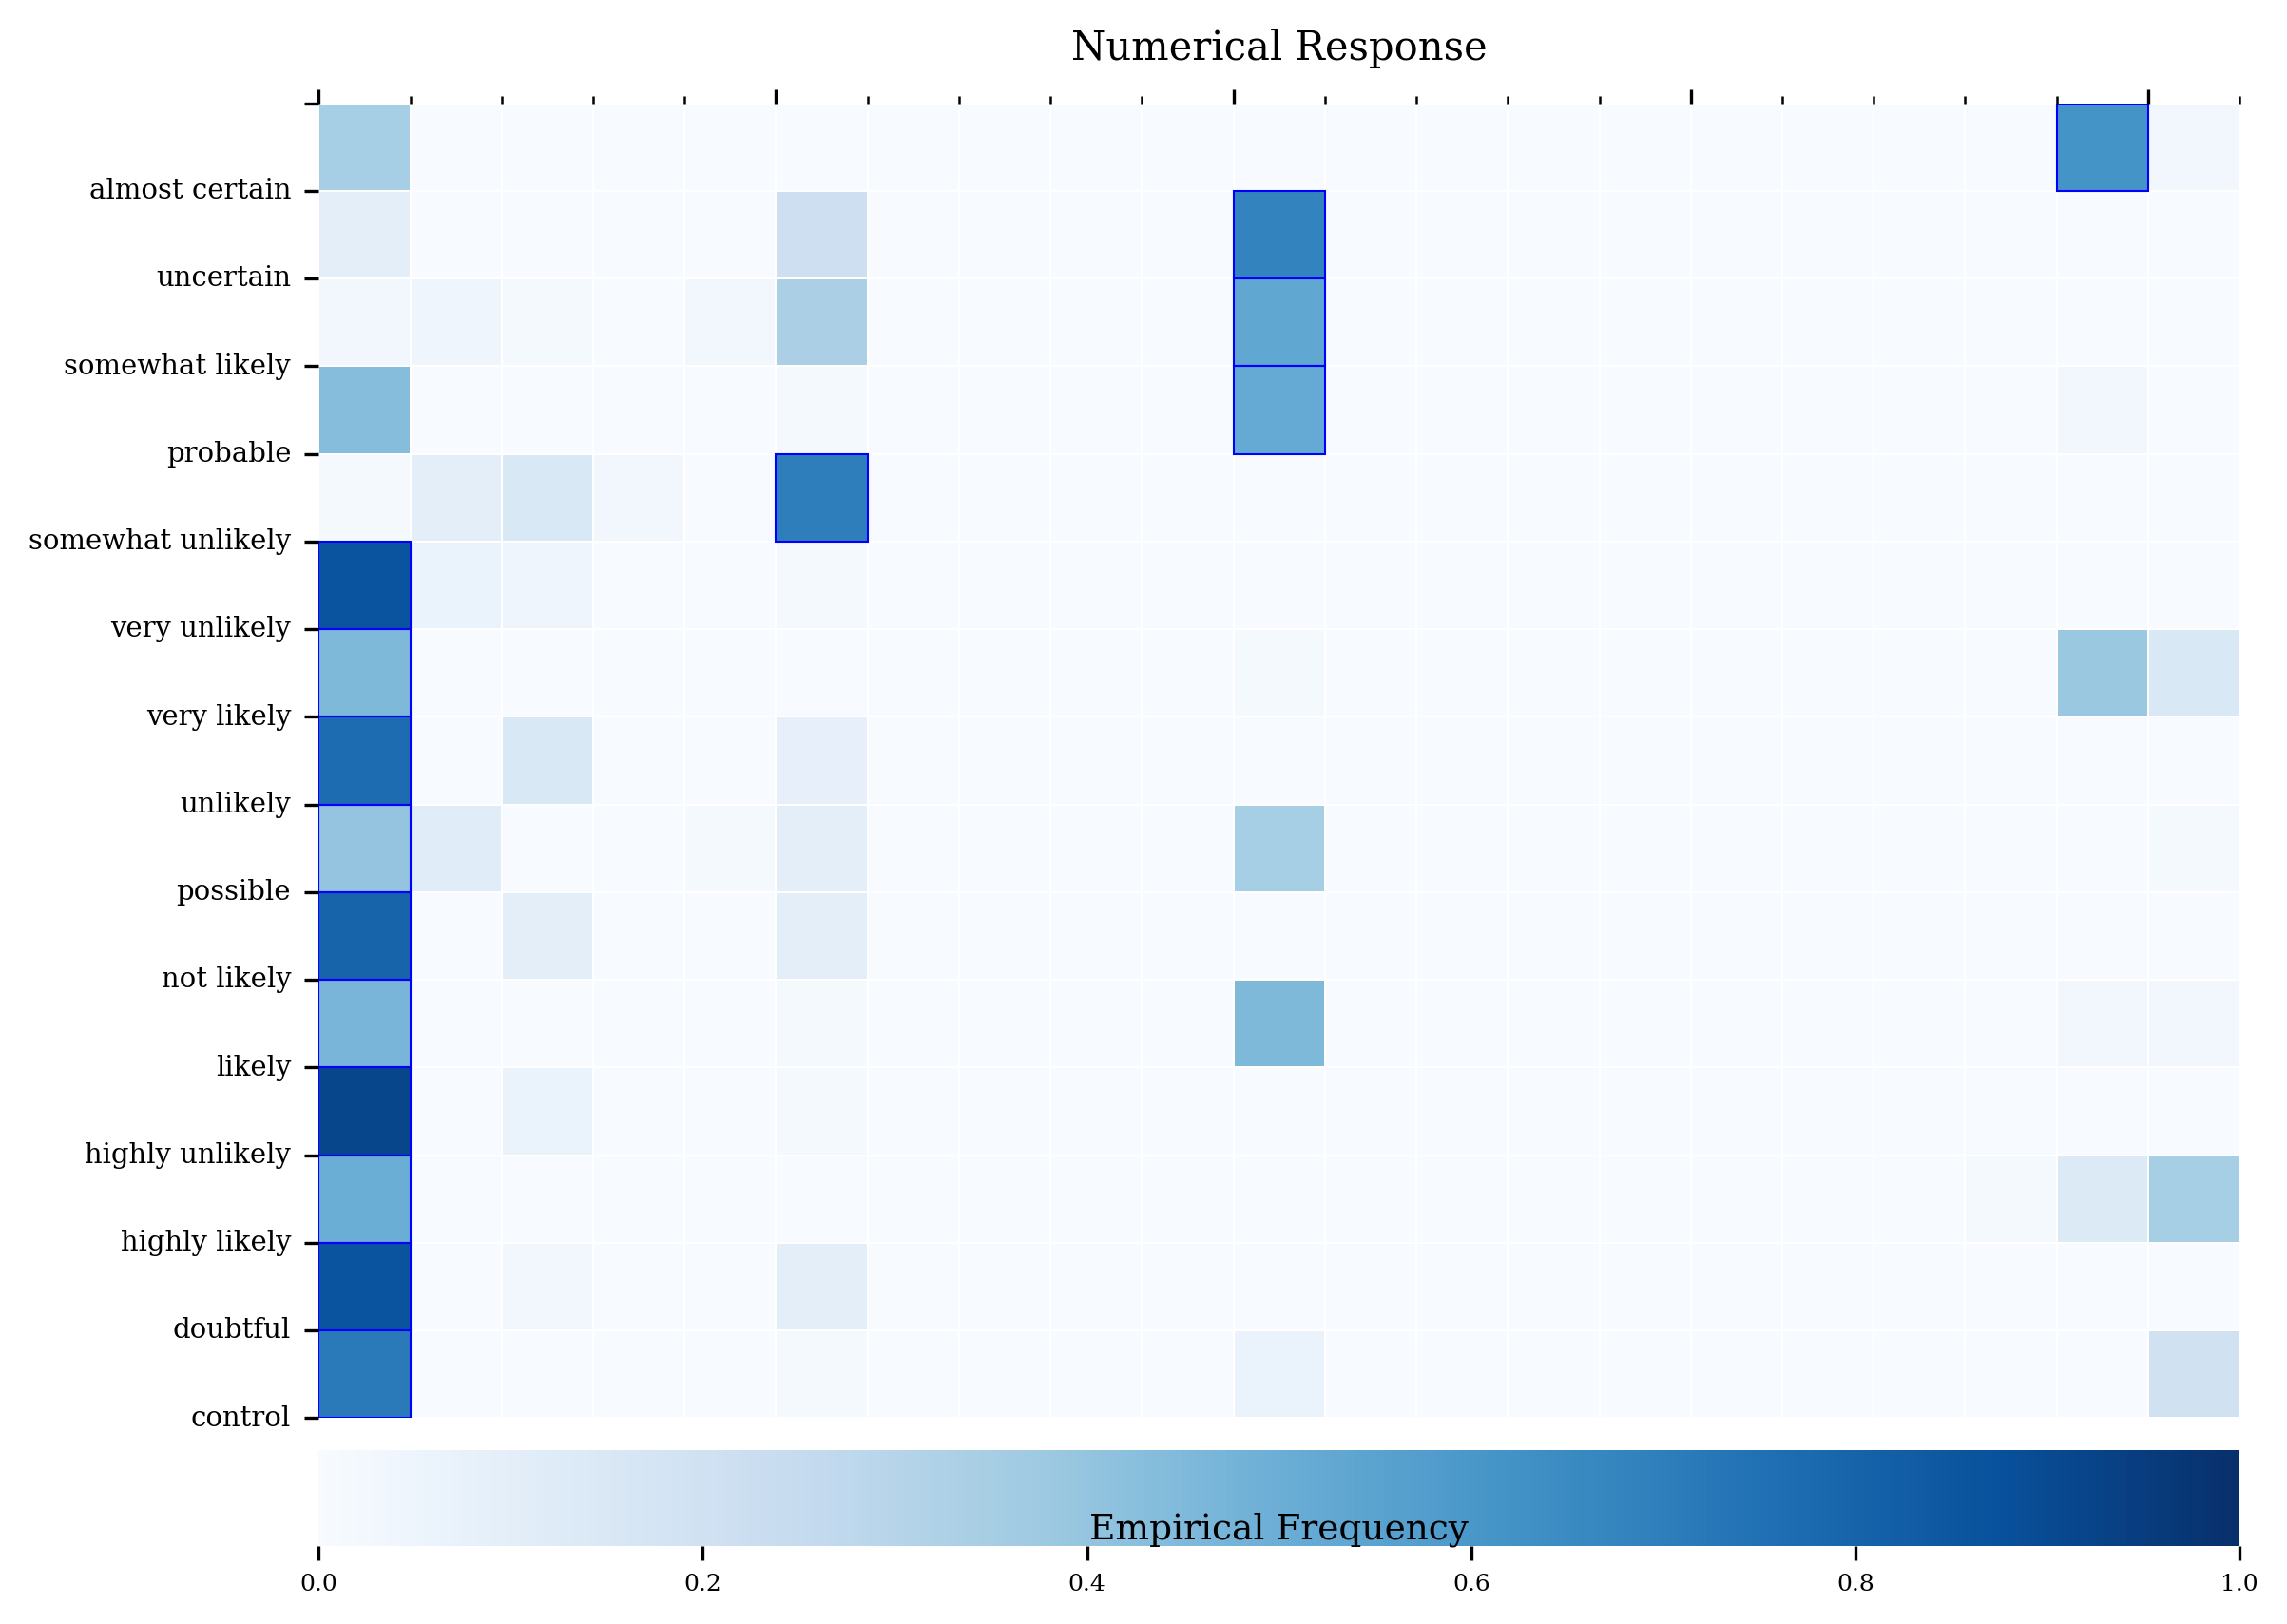

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# 读取生成的 CSV 文件
file_path = './daoyang_results/response_pivot_with_totals_4.csv'
data = pd.read_csv(file_path, index_col=0)

# 去除 'Total' 列，因为它不用于热力图
data_no_total = data.drop(columns=['Total'])

# 按每行最大值的位置排序
data_sorted = data_no_total.iloc[np.argsort(data_no_total.idxmax(axis=1))]

# 正则化数据（归一化到 0-1 之间，用于绘制频率热力图）
normalized_data = data_sorted.div(data_sorted.sum(axis=1), axis=0).fillna(0)

# 设置字体和绘图大小
plt.rc('font', family='serif', size=6)
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)

# 绘制热力图
heatmap_kwargs = dict(
    vmin=0, vmax=1, cmap="Blues", linecolor='white', linewidth=0.01,
    cbar_kws={
        'label': 'Empirical Frequency',
        'orientation': 'horizontal',
        'shrink': 1,
        'aspect': 20,
        'pad': 0.02,
    },
)
heatmap = sns.heatmap(normalized_data, ax=ax, **heatmap_kwargs)

# 调整颜色条
cbar = heatmap.collections[0].colorbar
cbar.set_label('Empirical Frequency', labelpad=-21, fontsize=9)
cbar.ax.tick_params(labelsize=6)

# 添加高亮框用于标注最大值
highlight_coords = np.argwhere(normalized_data.values == normalized_data.values.max(axis=1, keepdims=True))
for coord in highlight_coords:
    y, x = coord
    rect = plt.Rectangle([x, y], 1, 1, fill=False, edgecolor='blue', linewidth=0.5)
    ax.add_patch(rect)

# 调整标签和刻度
ax.set_xlabel("Numerical Response", fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_ylabel(None)
ax.yaxis.set_major_locator(MultipleLocator(1))

# 反转 y 轴
ax.invert_yaxis()

# 设置标签
ax.set_yticklabels([""] + normalized_data.index.tolist() + [""])

ax.tick_params(which="minor", bottom=False, left=True, top=True)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", fontsize=7)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=7)

# 保存图像
plt.tight_layout()
plt.savefig('./daoyang_results/sorted_response_inverted_heatmap_4.png', dpi=300)
plt.show()